In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

#from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.lgbm_model import LGBM_Model
#from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Note
### 從 new_features.ipynb 創建的特徵已完成

# Guideline

- Total: 5 models

- 基礎模型：由基礎特徵構建，包括 20 個原始特徵、13 個預處理特徵以及 60 個常用預處理特徵。

- 特殊特徵：4 個特殊特徵用來捕捉標籤資訊，因為有些使用者（bacno）同時出現在訓練集和測試集中。

- 每個四個模型都是以基礎特徵加上其中一個特殊特徵進行訓練。

- 如果測試集中的交易符合某個特殊特徵的條件，則該交易會由對應的特殊模型進行預測；否則則由基礎模型進行預測。

- 注意：這些特殊特徵在實際應用中可能無法使用，因為我們假設無法取得標籤。

# Key Takeaways

- **應用有限數量的新特徵**  
    - 為了簡化模型，提升模型的泛化能力。

- **如果訓練集中類別特徵的值不在測試集中，則替換為 NA**  
    - 這樣模型在測試集上應用時不會學到無用的資訊，模型可以專注於測試集中也存在的值。

- **使用Early Stopping 並用 GroupKFold 分割訓練集**  
    - 當模型在驗證集上的表現停止提升時，訓練將自動停止。  
    - 以使用者（bacno）分組訓練集可以讓模型更早停止，防止過擬合。

- **剔除極端值**  
    - 如果某折的預測結果超過 1 個標準差範圍，則丟棄該折的預測，因為測試集在不同折中的預測有些非常極端。


# Define features

In [3]:
# 布林型特徵 (Boolean Features)
raw_bool_features = ['ecfg',      # 網路交易註記
                     'flbmk',     # Fallback 註記
                     'flg_3dsmk', # 3DS交易註記
                     'insfg',     # 分期交易註記
                     'ovrlt'      # 超額註記碼
                      ]

# 類別型特徵 (Categorical Features)
raw_categorial_features = ['contp',  # 交易類別
                           'stscd',  # 狀態碼
                           'etymd',  # 交易型態
                           'stocn',  # 消費地國別
                           'mcc',    # MCC_CODE
                           'csmcu',  # 消費地幣別
                           'hcefg',  # 支付形態
                           'bacno',  # 歸戶帳號
                           'cano',   # 交易卡號
                           'mchno',  # 特店代號
                           'acqic',  # 收單行代碼
                           'scity'   # 消費城市
                            ] 

# 連續型特徵 (Continuous Features)
raw_contiuous_feautres = ['loctm',  # 授權時間
                          'conam',  # 交易金額-台幣(經過轉換)
                          'iterm'   # 分期期數
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',#同卡號，同一週期(30/60/90)出現的次數
                                  'cano_locdt_txkey_count',#同卡號，同一天出現的次數
                                  'bacno_locdt_mchno_txkey_count'#同帳號，同一天，同特店出現的次數
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',# 這間特店在過去的交易中有出現且是正常的
                    'mchno_in_fraud_mchno_list',# 這間特店在過去的交易中有出現且是盜刷的
                    'conam_in_fraud_conam_list',# 金額在過去的交易中有出現且是異常的
                    'diff_with_first_fraud_locdt'#與該卡號第一次被判盜刷距今的交易時間 
                               ]
new_features = ['bacno_cano_conam_mean_1h', 'bacno_cano_count_sum_1h',
       'bacno_cano_conam_mean_6h', 'bacno_cano_count_sum_6h',
       'bacno_cano_conam_mean_1d', 'bacno_cano_count_sum_1d',
       'bacno_cano_conam_mean_30d', 'bacno_cano_count_sum_30d',
       'bacno_cano_conam_mean_7d', 'bacno_cano_count_sum_7d',
       'bacno_cano_conam_mean_120d', 'bacno_cano_count_sum_120d',
       'bacno_cano_conam_mean_1h_xg_conam',
       'bacno_cano_conam_mean_6h_xg_conam',
       'bacno_cano_conam_mean_1d_xg_conam',
       'bacno_cano_conam_mean_7d_xg_conam',
       'bacno_cano_conam_mean_30d_xg_conam',
       'bacno_cano_conam_mean_120d_xg_conam', 'bacno_cano_count_sum_7d_xg_1h',
       'bacno_cano_count_sum_1d_xg_1h', 'bacno_cano_count_sum_6h_xg_1h',
       'bacno_cano_conam_mean_1h_div_conam',
       'bacno_cano_conam_mean_6h_div_conam',
       'bacno_cano_conam_mean_1d_div_conam',
       'bacno_cano_conam_mean_7d_div_conam',
       'bacno_cano_conam_mean_30d_div_conam',
       'bacno_cano_conam_mean_120d_div_conam']
new2_features = ['cano_mhcno_conam_mean_1h', 'cano_mhcno_count_sum_1h',
       'cano_mhcno_conam_mean_6h', 'cano_mhcno_count_sum_6h',
       'cano_mhcno_conam_mean_1d', 'cano_mhcno_count_sum_1d',
       'cano_mhcno_conam_mean_7d', 'cano_mhcno_count_sum_7d',
       'cano_mhcno_conam_mean_30d', 'cano_mhcno_count_sum_30d',
       'cano_mhcno_conam_mean_120d', 'cano_mhcno_count_sum_120d',
       'cano_mchno_conam_mean_1h_xg_conam',
       'cano_mchno_conam_mean_6h_xg_conam',
       'cano_mchno_conam_mean_1d_xg_conam',
       'cano_mchno_conam_mean_7d_xg_conam',
       'cano_mchno_conam_mean_30d_xg_conam',
       'cano_mchno_conam_mean_120d_xg_conam', 'cano_mhcno_count_sum_7d_xg_1h',
       'cano_mhcno_count_sum_1d_xg_1h', 'cano_mhcno_count_sum_6h_xg_1h',
       'cano_mhcno_conam_mean_1h_div_conam',
       'cano_mhcno_conam_mean_6h_div_conam',
       'cano_mhcno_conam_mean_1d_div_conam',
       'cano_mhcno_conam_mean_7d_div_conam',
       'cano_mhcno_conam_mean_30d_div_conam',
       'cano_mhcno_conam_mean_120d_div_conam']
new3_features = ['bacno_cano_stocn_unique_2d', 'bacno_cano_stocn_unique_6h',
       'bacno_cano_mchno_unique_2d', 'bacno_cano_mchno_unique_6h',
       'bacno_cano_mcc_unique_2d', 'bacno_cano_mcc_unique_6h']

base_features =  (    raw_bool_features 
                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features 
                    #+ new_features +new2_features +new3_features
                       )

label = 'fraud_ind'

# Preprocess

In [4]:
import os

# 檢查預處理檔案是否存在
preprocessed_file = 'data/df_preprocessed.pkl'
if os.path.exists(preprocessed_file):
    print(f"找到預處理檔案 {preprocessed_file}，直接載入...")
    df = pd.read_pickle(preprocessed_file)
else:
    print(f"未找到預處理檔案 {preprocessed_file}，開始執行預處理...")
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    print(f"預處理完成，儲存至 {preprocessed_file}")
    df.to_pickle(preprocessed_file)

找到預處理檔案 data/df_preprocessed.pkl，直接載入...


In [ ]:
#df_new3_x = pd.read_csv('new3_x_bacno_cano_category_count.csv',index_col=0)

In [ ]:
#df = pd.merge(df , df_new_x,on='txkey' , how='left')

In [ ]:
#df = pd.merge(df , df_new2_x,on='txkey' , how='left')

In [ ]:
#df = pd.merge(df , df_new3_x,on='txkey' , how='left')

In [ ]:
#len(df.columns) #確認合併後欄位數量

119

# Base features

In [5]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)# Replace the value of categorical features of training

X_train, y_train, groups, X_test = df_train[base_features], df_train[label], df_train['bacno_original'], df_test[base_features]
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,contp,stscd,etymd,stocn,mcc,csmcu,hcefg,bacno,cano,mchno,acqic,scity,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index
1943429,0,0,0,0,0,5.0,0.0,5.0,102.0,292.0,62.0,5.0,163884,211804,47022,6716.0,4526.0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1
1943430,1,0,0,0,0,5.0,0.0,8.0,102.0,209.0,62.0,5.0,163884,211804,38207,6322.0,5817.0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943431,0,0,0,0,0,5.0,0.0,5.0,102.0,270.0,62.0,5.0,163884,211804,39044,6716.0,5820.0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943432,0,0,0,0,0,5.0,0.0,5.0,102.0,306.0,62.0,5.0,163884,211804,88672,5975.0,5817.0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943433,0,0,0,0,0,5.0,0.0,5.0,102.0,192.0,62.0,5.0,163884,211804,89457,5975.0,5817.0,205657.0,366.38,0,9,1,1,84800.0,-240959.0,NaN,-12,NaN,366.38,366.38,NaN,0,1
1943434,0,0,0,0,0,5.0,0.0,5.0,102.0,288.0,62.0,5.0,163884,211804,88870,5975.0,5817.0,155256.0,1119.11,0,9,4,1,240959.0,-5347.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943435,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,163884,211804,6475,6767.0,5817.0,172203.0,1334.91,0,9,4,3,5347.0,-2025.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943436,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,163884,211804,6475,6767.0,5817.0,175548.0,1125.71,0,9,4,3,2025.0,-735.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,2
1943437,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,163884,211804,6475,6767.0,5817.0,180803.0,1103.64,0,9,4,3,735.0,-749289.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,3
1943438,1,0,0,1,0,5.0,0.0,8.0,102.0,247.0,62.0,5.0,163884,211804,82174,6769.0,5817.0,101612.0,1194.66,1,9,1,1,749289.0,NaN,NaN,0,NaN,1194.66,1194.66,NaN,0,1


# Base Model

In [7]:
lgbm = LGBM_Model(base_features) #等這跑完
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test,
                                                lgbm.lgbm_averge_precision, n_splits = 3)

Starting LightGBM. Fold 1,Train shape: (1521787, 33), test shape: (421665, 33)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 13318, number of negative: 1001206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64357
[LightGBM] [Info] Number of data points in the train set: 1014524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013127 -> initscore=-4.319844
[LightGBM] [Info] Start training from score -4.319844
Training until validation scores don't improve for 100 rounds
[100]	training's Averge Precision: 0.884882	valid_1's Averge Prec

# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [9]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)

In [10]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test.reset_index(drop=True,inplace=True)
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Whitelist of Merchant

In [12]:
input_features = base_features + [special_feautures[0]] #
X_train, y_train, groups, X_test = df_train[input_features], df_train[label], df_train['bacno_original'], df_test[input_features]

# X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['mchno_in_normal_mchno_list'].unique()

array([0, 1])

In [13]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 3 )

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 13318, number of negative: 1001206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64359
[LightGBM] [Info] Number of data points in the train set: 1014524, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013127 -> initscore=-4.319844
[LightGBM] [Info] Start training from score -4.319844
Training until validation scores don't improve for 100 rounds
[100]	training's Averge Precision: 0.884882	valid_1's Averge Prec

In [14]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_normal_mchno_model'] = oof_preds_LGBM
df_test['sub_normal_mchno_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Blacklist of Merchant

In [15]:
input_features = base_features + [special_feautures[1]]
X_train, y_train, groups, X_test = df_train[input_features], df_train[label], df_train['bacno_original'], df_test[input_features]
X_train['mchno_in_fraud_mchno_list'].unique()

array([0, 1])

In [17]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 3)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 13318, number of negative: 1001206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64357
[LightGBM] [Info] Number of data points in the train set: 1014524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013127 -> initscore=-4.319844
[LightGBM] [Info] Start training from score -4.319844
Training until validation scores don't improve for 100 rounds
[100]	training's Averge Precision: 0.884882	valid_1's Averge Prec

In [18]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_fraud_mchno_model'] = oof_preds_LGBM
df_test['sub_fraud_mchno_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Blacklist of Transaction Amount

In [19]:
input_features = base_features + [special_feautures[2]]
X_train, y_train, groups, X_test = df_train[input_features], df_train[label], df_train['bacno_original'], df_test[input_features]
X_train['conam_in_fraud_conam_list'].unique()

array([0, 1])

In [22]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 3
                                                 )

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 13318, number of negative: 1001206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64357
[LightGBM] [Info] Number of data points in the train set: 1014524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013127 -> initscore=-4.319844
[LightGBM] [Info] Start training from score -4.319844
Training until validation scores don't improve for 100 rounds
[100]	training's Averge Precision: 0.884882	valid_1's Averge Prec

In [23]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_fraud_conam_model'] = oof_preds_LGBM
df_test['sub_fraud_conam_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Elapsed Day of First Fraudulent Transaction(if exist)

In [40]:
input_features = base_features + [special_feautures[3]]
X_train, y_train, groups, X_test = df_train[input_features], df_train[label], df_train['bacno_original'], df_test[input_features]
#X_train['diff_with_first_fraud_locdt'].unique()

In [41]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision
                                                  , n_splits = 3)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 13318, number of negative: 1001206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64433
[LightGBM] [Info] Number of data points in the train set: 1014524, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013127 -> initscore=-4.319844
[LightGBM] [Info] Start training from score -4.319844
Training until validation scores don't improve for 100 rounds
[100]	training's Averge Precision: 0.89553	valid_1's Averge Preci

In [42]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_first_fraud_model'] = oof_preds_LGBM
df_test['sub_first_fraud_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Find the range of threshold which maximizes the f1 score

🚀 開始自動化閾值優化分析...
🔎 Searching for the optimal threshold...
➡️ Search range: 0.01 - 0.70, step: 0.01
➡️ Optimization metric: F1
--------------------------------------------------
Threshold 0.01: F1=0.447, Precision=0.302, Recall=0.865
Threshold 0.11: F1=0.647, Precision=0.592, Recall=0.712
Threshold 0.21: F1=0.666, Precision=0.680, Recall=0.652
Threshold 0.31: F1=0.668, Precision=0.739, Recall=0.610
Threshold 0.41: F1=0.663, Precision=0.780, Recall=0.577
Threshold 0.51: F1=0.654, Precision=0.814, Recall=0.547
Threshold 0.61: F1=0.640, Precision=0.841, Recall=0.517

🎯 Optimal Threshold Search Result
Best Threshold: 0.290
Best F1 Score: 0.669
F1 Score: 0.669
Precision: 0.729
Recall: 0.618
Predicted Positive Ratio: 0.011

📊 Recommended Thresholds for Different Scenarios:
Best F1 Balance: 0.290 (Score: 0.669)
Best Precision: 0.700 (Score: 0.867)
Best Recall: 0.010 (Score: 0.865)
High Precision Scenario: 0.470 (Score: 0.659)
High Recall Scenario: 0.030 (Score: 0.554)


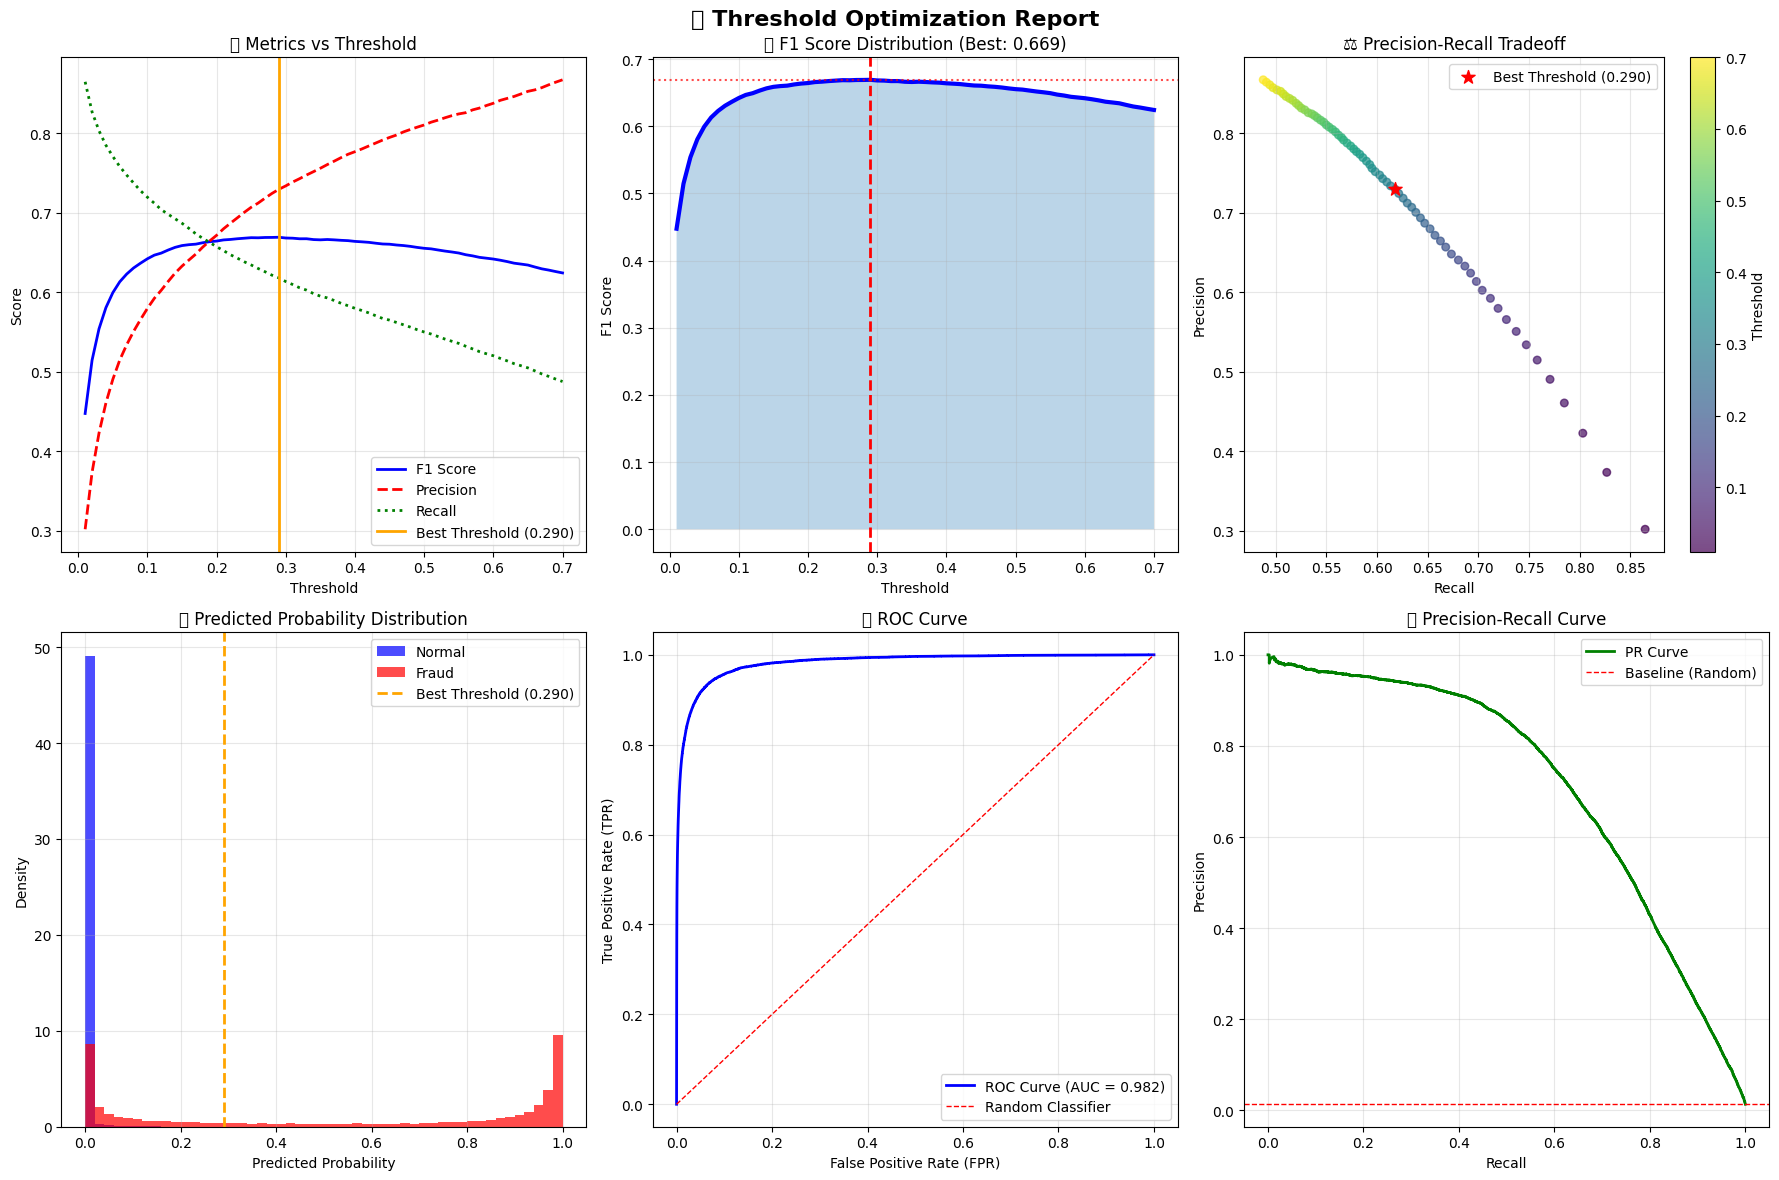


📊 Summary Statistics:
Number of thresholds searched: 70
Max F1 Score: 0.669
Max Precision: 0.867
Max Recall: 0.865
ROC AUC: 0.982

🎯 分析完成！
✅ 最佳閾值: 0.290
✅ 最佳F1得分: 0.669


In [ ]:
#from util.threshold_optimization import find_optimal_threshold, quick_threshold_optimization

def analyze_threshold_automatically(y_train, oof_predictions):
    """
    自動化閾值分析函數
    
    參數：
        y_train: 訓練集真實標籤
        oof_predictions: 模型的out-of-fold預測結果
    
    返回：
        dict: 包含最佳閾值和分析結果
    """
    
    print("開始自動化閾值優化分析...")
    print("=" * 60)
    
    # 執行全面的閾值優化分析
    result = find_optimal_threshold(
        y_true=y_train, 
        y_pred_proba=oof_predictions,
        threshold_range=(0.01, 0.70),  # 對應原來的 0-70%
        step=0.01,  # 對應原來的 1% 步長
        metric='f1',  # 優化F1得分
        plot=True,  # 生成視覺化圖表
        figsize=(18, 12)  # 大尺寸圖表
    )
    
    print("\n🎯 分析完成！")
    print("=" * 60)
    
    return result


result = analyze_threshold_automatically(y_train, df_train['oof_base_model'])

# 獲取最佳閾值
best_threshold = result['best_threshold']
best_f1_score = result['best_score']

print(f"✅ 最佳閾值: {best_threshold:.3f}")
print(f"✅ 最佳F1得分: {best_f1_score:.3f}")

# # 方法3：優化不同指標
# precision_result = find_optimal_threshold(y_train, df_train['oof_base_model'], metric='precision')
# recall_result = find_optimal_threshold(y_train, df_train['oof_base_model'], metric='recall')

# print(f"最佳精確率閾值: {precision_result['best_threshold']:.3f}")
# print(f"最佳召回率閾值: {recall_result['best_threshold']:.3f}")

## Create Submission

Use different models to predict based on different condiitons. Change the threshold to create submission. 

![描述文字](PredictFlow.png)

In [ ]:
threshold = result['best_threshold']

# 第1層：基礎判斷
df_test['fraud_ind'] = np.where(df_test['sub_base_model'] > threshold, 1, 0)

# 第2層：詐騙商戶特殊處理
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==1) & (df_test['sub_fraud_mchno_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==1) & (df_test['sub_fraud_mchno_model'] <= threshold), 0, df_test['fraud_ind'])

# 第3層：詐騙機台特殊處理
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['diff_with_first_fraud_locdt'] >= 1) & (df_test['sub_first_fraud_model'] > threshold), 1, df_test['fraud_ind'])

# 第4層：正常商戶特殊處理
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['mchno_in_normal_mchno_list']>0) & (df_test['sub_normal_mchno_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['mchno_in_normal_mchno_list']>0) & (df_test['sub_normal_mchno_model'] <= threshold), 0, df_test['fraud_ind'])

# 第5層：詐騙卡號特殊處理
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['conam_in_fraud_conam_list']==1) & (df_test['sub_fraud_conam_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['conam_in_fraud_conam_list']==1) & (df_test['sub_fraud_conam_model'] <= threshold), 0, df_test['fraud_ind'])

df_test[['txkey','fraud_ind']].to_csv('submission_{}.csv'.format(threshold),index = False)

In [47]:
df_test

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,days,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,global_time,last_time_days,next_time_days,cano_locdt_global_time_std,cano_last_trans_locdt,min,next_card_min,diff_locdt_of_two_card,diff_locdt_with_last_trans_cano,diff_locdt_with_last_trans_days_cano,locdt_head,locdt_tail,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index,cano_locdt_conam_min,cano_locdt_conam_max,conam_zero_trans_global_time,diff_gtime_with_conam_zero_trans_locdt,first_fraud_locdt,diff_with_first_fraud_locdt,normal_mchno,fraud_mchno,fraud_conam,rolling_normal_mchno,last_rolling_normal_mchno_cano,mchno_in_normal_mchno_list,rolling_fraud_mchno,last_rolling_fraud_mchno_cano,mchno_in_fraud_mchno_list,rolling_fraud_conam,last_rolling_fraud_conam_cano,conam_in_fraud_conam_list,sub_base_model,sub_normal_mchno_model,sub_fraud_mchno_model,sub_fraud_conam_model,sub_first_fraud_model
0,6189,0,114775,929.46,5,62,0,2,0,0,0,5,0,0,102,100045.0,343,87081,0,5817,102,0,1751253,120,1,1,1,8848845,NaN,NaN,NaN,102,102,NaN,NaN,0,18,102,102,0,1,929.46,929.46,NaN,NaN,NaN,NaN,[-999],[-999],[-999],[-999],NA,0,[-999],NA,0,[-999],NA,0,0.000014,0.000010,0.000014,0.000014,0.000010
1,5975,5,49266,225.84,5,62,0,4,0,0,0,5,0,0,119,101355.0,263,92577,0,5817,102,0,1688453,120,1,1,1,10318435,NaN,NaN,NaN,119,119,NaN,NaN,0,1,119,119,0,1,225.84,225.84,NaN,NaN,NaN,NaN,[-999],[-999],[-999],[-999],NA,0,[-999],NA,0,[-999],NA,0,0.000017,0.000029,0.000017,0.000017,0.000039
2,5112,6,213186,513.80,5,0,0,0,0,0,0,5,0,0,99,72127.0,453,544,0,0,102,0,635437,120,2,1,1,8580087,NaN,-1256694.0,NaN,113,99,NaN,NaN,-14,7,99,99,0,1,513.80,513.80,NaN,NaN,NaN,NaN,[-999],[-999],[-999],[-999],NA,0,[-999],NA,0,[-999],NA,0,0.000072,0.000088,0.000072,0.000072,0.000053
3,6769,6,213186,210.36,5,62,0,5,0,0,0,5,0,0,113,202621.0,251,84157,0,5817,102,0,417354,120,2,1,1,9836781,1256694.0,NaN,NaN,113,99,NaN,NaN,0,7,113,113,0,1,210.36,210.36,NaN,NaN,NaN,NaN,[-999],[-999],[-999],"[-999, -999]",[-999],0,"[-999, -999]",[-999],0,"[-999, -999]",[-999],0,0.000006,0.000010,0.000007,0.000007,0.000007
4,5982,10,59511,419.79,5,62,0,4,0,0,0,5,0,0,91,151539.0,251,24881,0,3297,102,0,888505,120,3,1,1,7917339,NaN,-66790.0,NaN,107,91,NaN,NaN,-16,13,91,91,0,1,419.79,419.79,NaN,NaN,NaN,NaN,[-999],[-999],[-999],[-999],NA,0,[-999],NA,0,[-999],NA,0,0.000006,0.000006,0.000006,0.000006,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421660,6215,163885,178691,0.00,5,62,0,2,0,0,0,5,0,0,96,154656.0,289,54828,0,3460,46,0,1932816,120,3,1,1,8351216,NaN,-864096.0,NaN,108,96,NaN,NaN,-12,12,96,106,10,1,0.00,0.00,8351216.0,0.0,NaN,NaN,[-999],[-999],[-999],"[-999, -999, -999, -999, -999, -999, -999, -99...",NA,0,"[-999, -999, -999, -999, -999, -999, -999, -99...",NA,0,"[-999, -999, -999, -999, -999, -999, -999, -99...",NA,0,0.005244,0.004568,0.005244,0.005244,0.007051
421661,6215,163885,178691,168.20,5,62,1,2,0,0,0,5,0,0,106,154832.0,289,54828,0,3460,46,0,1941526,120,3,1,1,9215312,864096.0,-166998.0,NaN,108,96,NaN,NaN,-2,12,96,106,10,2,168.20,168.20,NaN,NaN,NaN,NaN,[-999],[-999],[-999],"[-999, -999, -999, -999, -999, -999, -999, -99...","[-999, -999, -999, -999, -999, -999, -999, -99...",0,"[-999, -999, -999, -999, -999, -999, -999, -99...","[-999, -999, -999, -999, -999, -999, -999, -99...",0,"[-999, -999, -999, -999, -999, -999, -999, -99...","[-999, -999, -999, -999, -999, -999, -999, -99...",0,0.009504,0.013328,0.011709,0.011709,0.010540
421662,6557,163885,178691,1608.36,5,62,0,5,0,0,0,5,0,0,108,141150.0,288,31653,0,5817,102,0,1040128,120,3,1,1,9382310,166998.0,NaN,NaN,108,96,NaN,NaN,0,12,108,108,0,1,1608.36,1608.36,NaN,NaN,NaN,NaN,[-999],[-999],[-999],"[-999, -999, -999, -99